In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

In [ ]:
import os

lst = os.listdir('/content/drive/MyDrive/Mobilenet_pretrained2/Validation/bicycle') # your directory path
number_files = len(lst)
print(number_files)

530


In [ ]:
# Seed value
# Apparently you may use different seed values at each stage
seed_value= 2**30

# 1. Set the `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(seed_value)

# 2. Set the `python` built-in pseudo-random generator at a fixed value
import random
random.seed(seed_value)

# 3. Set the `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(seed_value)

# 4. Set the `tensorflow` pseudo-random generator at a fixed value
# import tensorflow as tf
tf.random.set_seed(seed_value)
# for later versions:
# tf.compat.v1.set_random_seed(seed_value)

# 5. Configure a new global `tensorflow` session
from keras import backend as K
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
K.set_session(sess)
# for later versions:
# session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
# sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
# tf.compat.v1.keras.backend.set_session(sess)



In [ ]:
train_dir = os.path.join("/content/drive/MyDrive/Mobilenet_pretrained2", 'Train')
validation_dir = os.path.join("/content/drive/MyDrive/Mobilenet_pretrained2", 'Validation')

BATCH_SIZE = 32
IMG_SIZE = (160, 160)

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

Found 1338 files belonging to 2 classes.


In [ ]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 573 files belonging to 2 classes.


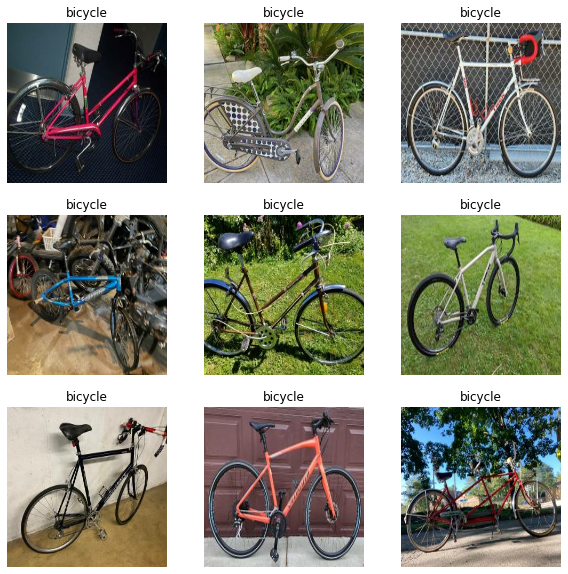

In [ ]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")


In [ ]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

In [ ]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))



Number of validation batches: 15
Number of test batches: 3


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)


### AUGMENTATION FOR CYCLES

In [ ]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

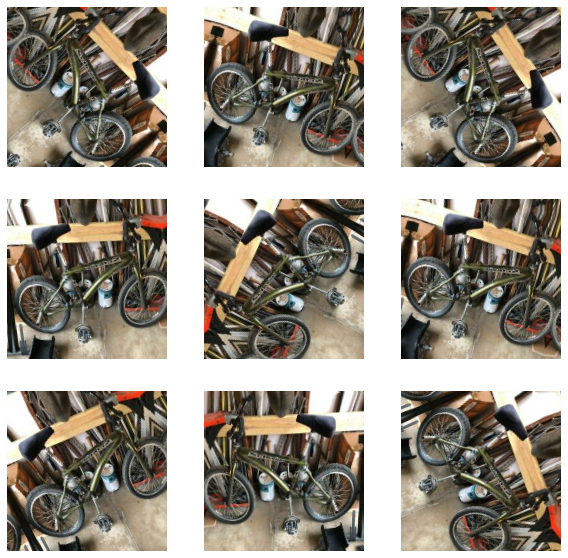

In [ ]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[1]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [ ]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [ ]:

rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)


In [ ]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [ ]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


In [ ]:
base_model.trainable = False

In [ ]:
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 80, 80, 32)   0           ['bn_Conv1[0][

In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [ ]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


In [ ]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [ ]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 160, 160, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 160, 160, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                             

In [ ]:
len(model.trainable_variables)


2

In [ ]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)

15/15 [==============================] - 21s 913ms/step - loss: 0.6381 - accuracy: 0.8449


In [ ]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.64
initial accuracy: 0.84


In [ ]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10
42/42 [==============================] - 63s 1s/step - loss: 0.4995 - accuracy: 0.8617 - val_loss: 0.3374 - val_accuracy: 0.9203
Epoch 2/10
42/42 [==============================] - 48s 1s/step - loss: 0.3269 - accuracy: 0.9081 - val_loss: 0.2795 - val_accuracy: 0.9224
Epoch 3/10
19/42 [============>.................] - ETA: 18s - loss: 0.3241 - accuracy: 0.9013

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
base_model.trainable = True

In [ ]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False



In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

In [ ]:
model.summary()


In [ ]:
len(model.trainable_variables)


In [ ]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

In [ ]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']


In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
loss, accuracy = model.evaluate(test_dataset)
# X, y = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

In [ ]:
# Retrieve a batch of images from the test set

image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)


In [ ]:
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(30):
  ax = plt.subplot(6, 5, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

In [ ]:
import seaborn as sns
sns.heatmap(tf.math.confusion_matrix(
    label_batch,
    predictions.numpy(),
    num_classes=None,
    weights=None,
    dtype=tf.dtypes.int32,
    name=None
), annot=True)


In [ ]:
import glob
post_id = [f[-14:-4] for f in glob.glob("/content/drive/MyDrive/Test_Images/*.jpg")]

In [ ]:
len(post_id)

In [ ]:
from PIL import Image
from matplotlib.pyplot import imshow
# Read image
#opening all the images and saving it in an array
craig_imgs_arr = np.array([np.array(Image.open("/content/drive/MyDrive/Test_Images/" + i +".jpg")) for i in post_id])

In [ ]:
craig_imgs_arr_resized = np.array([Image.fromarray(i).resize((160,160)) for i in craig_imgs_arr])

In [ ]:
np.array(craig_imgs_arr[0]).shape

In [ ]:
craig_imgs_arr_resized_axised = np.array([np.array(i)[np.newaxis, ...] for i in craig_imgs_arr_resized])

In [ ]:
imshow(craig_imgs_arr[1])

In [ ]:
craig_labels={'Post ID':[],'y_pred_label_img':[],'prob_img':[]}
for i in range(0,len(post_id)):
  pred = model.predict(craig_imgs_arr_resized_axised[i]).flatten()
  pred = tf.nn.sigmoid(pred)
  craig_labels['prob_img'].append(pred.numpy()[0])
  pred = tf.where(pred < 0.5, 0, 1)
  craig_labels['Post ID'].append(post_id[i])
  craig_labels['y_pred_label_img'].append(pred.numpy()[0])

# print('Predictions:\n', pred.numpy())

In [ ]:
import pandas as pd
df_craig_pred=pd.DataFrame(craig_labels)

In [ ]:
df_craig_pred.to_csv('/content/drive/MyDrive/post_labels_cincinnati.csv')


In [ ]:
df_craig_pred

## Ensemble

In [ ]:
df_text_op= pd.read_csv('/content/drive/MyDrive/Cincinnati_text_model_output.csv')

In [ ]:
df_text_op['Post ID']=df_text_op['Post ID'].astype(str)

In [ ]:
df_ensemble=pd.merge(df_craig_pred,df_text_op, on = 'Post ID', how='left')

In [ ]:
df_ensemble['text_pred_new']=1-df_ensemble['text_pred'] 

In [ ]:
df_ensemble['y_pred_text_label']=df_ensemble['text_pred_new'].apply(lambda x : 1 if (x > 0.5) else 0)

In [ ]:
df_ensemble['y_pred_ensemble']=0.35*df_ensemble['text_pred_new'] + 0.65*df_ensemble['prob_img'] 

In [ ]:
df_ensemble['y_pred_ensemble_label']=df_ensemble['y_pred_ensemble'].apply(lambda x : 1 if (x > 0.5) else 0)

In [ ]:
df_ensemble.head()

# Confusion Matrix : Image

In [ ]:
from sklearn.metrics import confusion_matrix
cf_matrix=confusion_matrix(df_ensemble['y_true'], df_ensemble['y_pred_label_img'])
import seaborn as sns

sns.heatmap(cf_matrix, annot=True,fmt=".0f")

# Confusion Matrix: Text

In [ ]:
from sklearn.metrics import confusion_matrix
cf_matrix=confusion_matrix(df_ensemble['y_true'], df_ensemble['y_pred_text_label'])
import seaborn as sns

sns.heatmap(cf_matrix, annot=True,fmt=".0f")

# Confusion Matrix : Ensemble

In [ ]:
from sklearn.metrics import confusion_matrix
cf_matrix=confusion_matrix(df_ensemble['y_true'], df_ensemble['y_pred_ensemble_label'])
import seaborn as sns

sns.heatmap(cf_matrix, annot=True,fmt=".0f")

In [ ]:
df_ensemble[(df_ensemble['y_pred_label_img']==1) & (df_ensemble['y_pred_text_label']==0)]

In [ ]:
df_ensemble.to_csv('HUSTLERS_FINAL_OUTPUT_AUD_ENSEMBLE.csv')